# BUND - Extract BBSIS 10-Year Yield Data

This notebook extracts data from the BUND CSV file, specifically the 10-year yield data (BBSIS.D.I.ZAR.ZI.EUR.S1311.B.A604.R10XX.R.A.A._Z._Z.A).

The output CSV will contain the date and value columns, with backward fill (bfill) applied to handle missing values.


In [1]:
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')


In [2]:
# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

# Define input and output files
input_file = 'data/bund/bbsis/BBSIS.D.I.ZAR.ZI.EUR.S1311.B.A604.R10XX.R.A.A._Z._Z.A.csv'
output_file = 'data/bund/bbsis/BBSIS_10_YEARS_YIELDS.csv'

# Check that the input file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"File not found: {input_file}")

print(f"Input file: {input_file}")
print(f"Output file: {output_file}")


Working directory: /workspace
Input file: data/bund/bbsis/BBSIS.D.I.ZAR.ZI.EUR.S1311.B.A604.R10XX.R.A.A._Z._Z.A.csv
Output file: data/bund/bbsis/BBSIS_10_YEARS_YIELDS.csv


In [3]:
# Read the CSV file
# The file has 8 header rows (lines 1-8), data starts at line 9 (index 8)
# Format: date, value (can be "." for missing), flags
print("Reading CSV file...")
df = pd.read_csv(input_file, skiprows=8, header=None, names=['date', 'value', 'flags'])

print(f"Data shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nData info:")
print(df.info())


Reading CSV file...
Data shape: (10354, 3)

First few rows:
         date value               flags
0  1997-08-01     .  No value available
1  1997-08-02     .  No value available
2  1997-08-03     .  No value available
3  1997-08-04     .  No value available
4  1997-08-05     .  No value available
5  1997-08-06     .  No value available
6  1997-08-07  5.76                 NaN
7  1997-08-08  5.76                 NaN
8  1997-08-09     .  No value available
9  1997-08-10     .  No value available

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10354 entries, 0 to 10353
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    10354 non-null  object
 1   value   10354 non-null  object
 2   flags   3160 non-null   object
dtypes: object(3)
memory usage: 242.8+ KB
None


In [4]:
# Extract only date and value columns
df_extracted = df[['date', 'value']].copy()

# Convert date column to datetime
df_extracted['date'] = pd.to_datetime(df_extracted['date'], format='%Y-%m-%d', errors='coerce')

# Remove rows where date is invalid
df_extracted = df_extracted[df_extracted['date'].notna()].copy()

# Replace "." with NaN in value column
df_extracted['value'] = df_extracted['value'].replace('.', pd.NA)

# Convert value column to numeric
df_extracted['value'] = pd.to_numeric(df_extracted['value'], errors='coerce')

# Sort by date to ensure proper order
df_extracted = df_extracted.sort_values(by='date').reset_index(drop=True)

print(f"Date range: {df_extracted['date'].min()} to {df_extracted['date'].max()}")
print(f"Total rows: {len(df_extracted)}")
print(f"\nMissing values before bfill:")
print(df_extracted.isnull().sum())
print(f"\nFirst few rows:")
print(df_extracted.head(10))


Date range: 1997-08-01 00:00:00 to 2025-12-05 00:00:00
Total rows: 10354

Missing values before bfill:
date        0
value    3160
dtype: int64

First few rows:
        date  value
0 1997-08-01    NaN
1 1997-08-02    NaN
2 1997-08-03    NaN
3 1997-08-04    NaN
4 1997-08-05    NaN
5 1997-08-06    NaN
6 1997-08-07   5.76
7 1997-08-08   5.76
8 1997-08-09    NaN
9 1997-08-10    NaN


In [5]:
# Apply backward fill (bfill) to fill missing values
# This fills missing values with the next available value
df_extracted['value'] = df_extracted['value'].bfill()

print(f"Missing values after bfill:")
print(df_extracted.isnull().sum())
print(f"\nFinal data preview:")
print(df_extracted.head(10))
print(f"\n...")
print(df_extracted.tail(10))


Missing values after bfill:
date     0
value    0
dtype: int64

Final data preview:
        date  value
0 1997-08-01   5.76
1 1997-08-02   5.76
2 1997-08-03   5.76
3 1997-08-04   5.76
4 1997-08-05   5.76
5 1997-08-06   5.76
6 1997-08-07   5.76
7 1997-08-08   5.76
8 1997-08-09   5.75
9 1997-08-10   5.75

...
            date  value
10344 2025-11-26   2.71
10345 2025-11-27   2.72
10346 2025-11-28   2.72
10347 2025-11-29   2.76
10348 2025-11-30   2.76
10349 2025-12-01   2.76
10350 2025-12-02   2.79
10351 2025-12-03   2.79
10352 2025-12-04   2.79
10353 2025-12-05   2.82


In [6]:
# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Format date as string (YYYY-MM-DD) for CSV output
df_to_save = df_extracted.copy()
df_to_save['date'] = df_to_save['date'].dt.strftime('%Y-%m-%d')

# Save to CSV (format: date,value)
df_to_save.to_csv(output_file, index=False)
print(f"File saved successfully: {output_file}")
print(f"Dimensions: {len(df_to_save)} rows, {len(df_to_save.columns)} columns")
print(f"\nFinal data summary:")
print(df_extracted.describe())


File saved successfully: data/bund/bbsis/BBSIS_10_YEARS_YIELDS.csv
Dimensions: 10354 rows, 2 columns

Final data summary:
                      date         value
count                10354  10354.000000
mean   2011-10-03 12:00:00      2.580946
min    1997-08-01 00:00:00     -0.850000
25%    2004-09-01 06:00:00      0.700000
50%    2011-10-03 12:00:00      2.700000
75%    2018-11-03 18:00:00      4.180000
max    2025-12-05 00:00:00      5.790000
std                    NaN      1.850981


Plot saved to: data/bund/bbsis/BBSIS_10_YEARS_YIELDS_plot.png


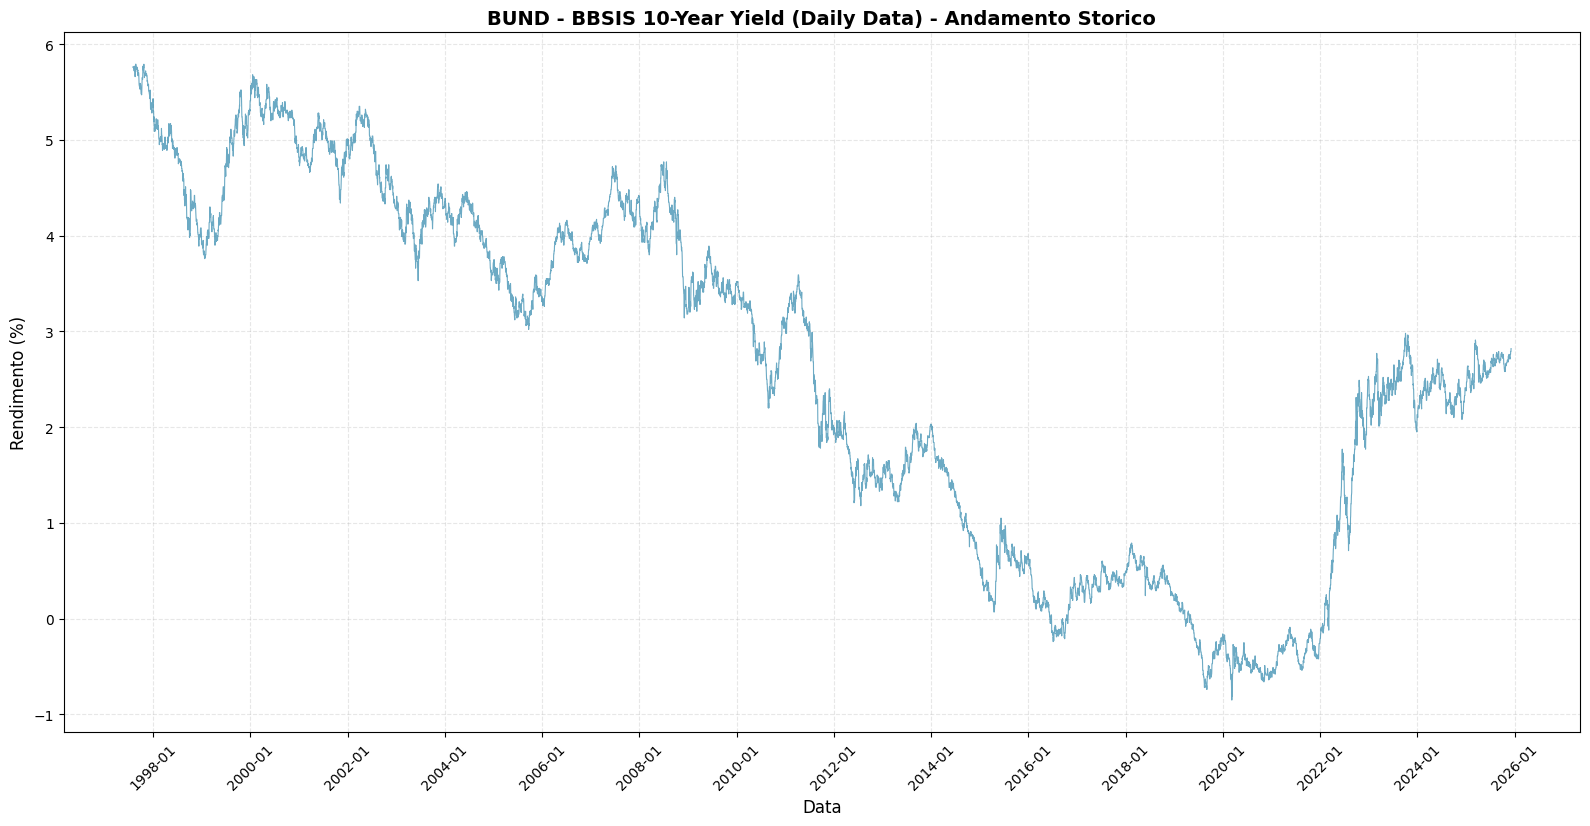

In [7]:
# Create a plot of the data
plt.figure(figsize=(16, 8))
plt.plot(df_extracted['date'], df_extracted['value'], linewidth=0.8, color='#2E86AB', alpha=0.7)
plt.title('BUND - BBSIS 10-Year Yield (Daily Data) - Andamento Storico', 
          fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Rendimento (%)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
plt.xticks(rotation=45)

# Save plot
plot_file = os.path.join(os.path.dirname(output_file), 'BBSIS_10_YEARS_YIELDS_plot.png')
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Plot saved to: {plot_file}")

plt.show()
